In [5]:
import scipy
import numpy as np
import pandas as pd
import itertools as it

from math import sin
import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import scale

from scipy.stats.stats import pearsonr 

from scipy.stats import invgamma 
from scipy.stats import beta

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

from sklearn.metrics import silhouette_samples, silhouette_score


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import StructE_tools as Ste

from Generate_freq_vectors import generate_vectors_Beta

## Distribution of euclidian distance.

Modular genome simulation.

The functions in this directory serve to construct synthetic genomic data sets following to user-specified demands.

Parameters include:

- Number of populations and sample sizes.
- Local genetic distances between sources of genetic diversity.
- Population specific recombination probabilities and recombination map.





## I. Model local genomic structure



In [6]:
Nbranches= 4
L= 150
n= 100
rangeA= [1,2.5]
rangeB = [.1,.6]
steps= 20
n_comp = 100
density= 50


vector_lib= generate_vectors_Beta(L,n,rangeA,rangeB,steps,n_comp)

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
features = pca.transform(vector_lib)

print(features.shape)
print(vector_lib.shape)

(2000, 100)
(2000, 150)


In [7]:
### Functions to manipulate genetic structure.

def sin_prior(coords,angle,target= [0,1],fst_max= 0.2,passport= False):
    
    vector2= coords[target[0]] - coords[target[1]]
    
    ID= 'sinusoid'
    
    coords[target[0]] = coords[target[0]] - [(fst_max * 10 - 1) * sin(angle) * x for x in vector2]
    
    if passport:
        return coords,ID
    else:
        return coords


def linear_prior(coords,angle,target= [0,1],region= [-5,5],slope= 1,passport= False):
    
    vector2= coords[target[0]] - coords[target[1]]
    
    ID= 'linear'
    
    if angle >= region[0] and angle <= region[1]:
        progression= abs(angle - region[0]) / (region[1] - region[0])
        coords[target[0]] = coords[target[0]] + [progression * x * slope for x in vector2]
    
    if passport:
        return coords,ID
    else:
        return coords


def introgression_prior(coords,angle,target= [0,1],region= [0,1],passport= False):
        
    ID= 'introgression'
    
    if angle >= region[0] and angle <= region[1]:
        coords[target[0]] = coords[target[1]]
    
    if passport:
        return coords,ID
    else:
        return coords
    

def alien_prior_I(coords,angle,target= [0,1],fst= .2,region= [-5,5],passport= False):
    ID= 'alien I'
    
    vector2= coords[target[0]] - coords[target[1]]
    
    if angle >= region[0] and angle <= region[1]:
        coords[target[0]] = coords[target[0]] + [(10 * fst - 1) * x for x in vector2]
        #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2] remember to try this though
        #coords[target[0]] = coords[len(coords) - 1]
    else:
        coords[target[0]] = coords[target[1]]
    
    if passport:
        return coords,ID
    else:
        return coords


def alien_prior_II(coords,angle,target= [0,1],fst= .2,region= [-5,5],passport= False):
    ID= 'alien II'
    
    vector2= coords[target[0]] - coords[target[1]]
    
    if angle >= region[0] and angle <= region[1]:
        coords[target[0]] = coords[target[0]] + [(10 * fst - 1) * x for x in vector2]
        #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2] remember to try this though
        #coords[target[0]] = coords[len(coords) - 1]
    
    if passport:
        return coords,ID
    else:
        return coords


def alien_prior_III(coords,angle,target= [0,1],fst_a= 0.2,fst_b= .2,region= [-5,5],passport= False):
    ID= 'alien III'
    vector2= coords[target[0]] - coords[target[1]]
    
    if angle >= region[0] and angle <= region[1]:
        coords[target[0]] = coords[target[0]] + [(10 * fst_b-1) * x for x in vector2]
        #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2] remember to try this though
        #coords[target[0]] = coords[len(coords) - 1]
    else:
        coords[target[0]] = coords[target[0]] + [(10 * fst_a-1) * x for x in vector2]
    
    if passport:
        return coords,ID
    else:
        return coords



In [8]:
from Generate_samples import Check_Path, plot_GenFst, return_fsts2


Sizes= [100,100,100,100]

Npops= len(Sizes)

range_diff= [0,20]


prior_kwargs= {
    'fst': .3,
    'region': [3,6],
    'target': [0,2]
}

prior_func= alien_prior_I

fig, Pops, prior= Check_Path(Npops,vector_lib,prior_func,prior_kwargs,Pops= [],random= True,n_comp= L,range_diff= range_diff,steps= 100)

iplot(fig)

C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Simulate_genomes\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



In [9]:
## We now have our populations. These are not yet represented by any samples. 
## Next we will produce samples. we could stick to simply produce samples from each vector, but we can 
## go a bit further. We can add some characteristics to these populations:

##### Admixture proportion
##### Recombination map

## let's begin with the simpler of the two: recombination map.
## we will make this a function of the progression of our window along our proxy genome range.

def Rec_prob_uniform(angle,range_windows,Cop):
    ID= 'uniform'
    return Cop, ID

def Rec_prob_sinusoid(angle,range_windows,Cop_range):
    ID= 'sinusoid'
    
    progress= (angle - range_windows[0]) #/ (range_windows[1] - range_windows[0])
    #print(progress)
    Cop= (sin(progress) + 1) * Cop_range
    
    return Cop, ID

def Rec_prob_modal(angle,range_windows,modes,multiplier,N= 100,bandwidth= .2):
    ID= 'modal. modes: {}'.format(modes)
    N_modes= len(modes)
    progress= (angle - range_windows[0]) / (range_windows[1] - range_windows[0])
    
    sam= np.repeat(modes,N)
    sam= np.array(sam).reshape(-1,1)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sam)
    
    log_dens = kde.score_samples(progress)
    
    Cop= np.exp(log_dens)[0] * multiplier
    #print(Cop)
    return Cop, ID

def Rec_prob_region(angle,range_windows,region,prob_basal,prob):
    ID= 'region'
    progress= (angle - range_windows[0]) / (range_windows[1] - range_windows[0])
    
    if progress >= region[0] and progress <= region[1]:
        Cop= prob
    else:
        Cop= prob_basal
    
    return Cop, ID
    

def Rec_prob_rdist(angle,range_windows,multiplier,c,loc,scale):
    ID= 'rdist'
    #Size= (range_windows[1] - range_windows[0])
    
    progress= (angle - range_windows[0]) / ((range_windows[1] - range_windows[0]) / 2) - 1 
    #print(progress)
    
    Cop= multiplier * scipy.stats.rdist.pdf(progress,c,loc,scale)
    if Cop > 1:
        Cop= 1
    if Cop < 0:
        Cop= 0
    
    return Cop, ID


#####
Cop_lib= {
    'uniform':{
        'Cop_func': Rec_prob_uniform,
        'Cop_kwargs': {
            'Cop': 1e-3
        }
    },
    'sinusoid': {
        'Cop_func': Rec_prob_sinusoid,
        'Cop_kwargs': {
            'Cop_range': .4 
        }
    },
    'modal': {
        'Cop_func': Rec_prob_modal,
        'Cop_kwargs': {
            'modes': [.2,.5,.7],
            'N':100,
            'bandwidth': 0.05,
            'multiplier': 5*1e-2
        }
    },
    'region': {
        'Cop_func': Rec_prob_region,
        'Cop_kwargs': {
            'region': [.4,.6],
            'prob_basal': 0,
            'prob':.2
        }
    },
    'rdist': {
        'Cop_func': Rec_prob_rdist,
        'Cop_kwargs': {
            'multiplier': float(1 / 6),
            'c': .9,
            'loc': 0,
            'scale': 1
        }
    }
}

#####

from plotly import tools
from Recombination_tools import Check_cop

Ncols= 2
titles= list(Cop_lib.keys())
print(titles)

fig_subplots = tools.make_subplots(rows= int(len(Cop_lib) / float(Ncols)) + (len(Cop_lib) % Ncols > 0), cols=Ncols,
                         subplot_titles=tuple(titles))


#####
for gp in range(len(titles)):
    
    pos1= int(float(gp) / Ncols) + 1
    pos2= gp - (pos1-1)*Ncols + 1
    
    title= titles[gp]
    
    Cop_func= Cop_lib[title]['Cop_func']
    Cop_kwargs= Cop_lib[title]['Cop_kwargs']
        
    fig= Check_cop(Cop_func,Cop_kwargs,steps= 500,range_diff= range_diff)

    trace1= fig['data'][0]

    fig_subplots.append_trace(trace1, pos1, pos2)
    
    fig_subplots['layout']['yaxis' + str(gp + 1)].update(title='Rec prob')
    #fig_subplots['layout']['xaxis' + str(gp + 1)].update(title='Position')


layout = go.Layout(
    title= 'Recombination along synth range',
    yaxis=dict(
        title='Rec proba'),
    xaxis=dict(
        title='Position')
)

fig= go.Figure(data=fig_subplots, layout=layout)
iplot(fig_subplots)

['uniform', 'sinusoid', 'modal', 'region', 'rdist']
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\scipy\stats\_continuous_distns.py:4841: RuntimeWarning:

divide by zero encountered in power



In [10]:
int(len(Cop_lib) / float(Ncols))

2

In [12]:
### Reading the sNMF output, and classing according to an inclusion threshold.

from Generate_samples import OriginbySNMF
inclusion_threshold= .8

Geno_Q = "Complementary_data/sNMF_out3K.Q"
Geneo, Ind_admx = OriginbySNMF(Geno_Q,inclusion_threshold)

snmf_gps= sorted(Geneo.keys())

#####
from plotly import tools

fig_box_subplots = tools.make_subplots(rows=2, cols=2,
                         subplot_titles=tuple(['Gp: {}'.format(x) for x in snmf_gps]))

Ncols= 2

for gp in range(len(snmf_gps)):
    
    pos2= int(float(gp) / Ncols) + 1
    pos1= gp - (pos2-1)*Ncols + 1
    
    for prop in range(len(snmf_gps) - 1):
        trace= go.Box(
            y= [x[prop] for x in Geneo[gp]],
            name= 'gp: {}, Anc: {}'.format(gp,prop)
        )
        
        fig_box_subplots.append_trace(trace, pos1, pos2)
    
    fig_box_subplots['layout']['yaxis' + str(gp + 1)].update(title='Admixture proportion')
    fig_box_subplots['layout']['xaxis' + str(gp + 1)].update(title='group')

layout = go.Layout(
    title= 'Admix proportion by grp',
    yaxis=dict(
        title='Admx prop'),
    xaxis=dict(
        title='Gp')
)

fig= go.Figure(data=fig_box_subplots, layout=layout)
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [13]:
Cop_choice= {
    0:{
        'cop_func': Rec_prob_region,
        'cop_kwargs': {
            'region': [.4,.6],
            'prob_basal': 0,
            'prob': .8
        }
    },
    1:{
        'cop_func': Rec_prob_region,
        'cop_kwargs': {
            'region': [.4,.6],
            'prob_basal': 0,
            'prob': .8
        }
    },
    2:{
        'cop_func': Rec_prob_region,
        'cop_kwargs': {
            'region': [.4,.6],
            'prob_basal': 0,
            'prob': .8
        }
    },
    3:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    }
}


In [14]:
snmf_sim= {
    0:1,
    1:0,
    2:2,
    3:3
}

from random import sample

Origins= {x: sample(Geneo[snmf_sim[x]], Sizes[x]) for x in snmf_sim.keys()}

Origins= {x: {y:Origins[x][y] for y in range(len(Origins[x]))} for x in Origins.keys()}

labels= [x for x in range(len(snmf_sim)-1)]
#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1

label_package= {
    'labels':labels,
    'Whose': Whose,
    'ind_to_group': ind_to_group,
    'label_vector': label_vector
}

In [15]:
########
########
from Generate_samples import Gen_samples_II

window_size= 5e3
Chr= 1

# Gen_samples_II(Pops,Sizes,vector_lib,label_package,Origins,prior_func,prior_kwargs,Cop_choice,window_size= 5000,Chr= 1,return_pca= False,n_comp= 100,range_diff= [-10,10],steps= 100):


Windows, Fst_windows, Ideo, Out= Gen_samples_II(Pops,Sizes,vector_lib,label_package,Origins,prior_func,prior_kwargs,Cop_choice,window_size= window_size,Chr= Chr,range_diff=range_diff)

...


C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Simulate_genomes\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



Done.


In [11]:
plot_GenFst(Fst_windows,Npops,1)

adding ideograms...


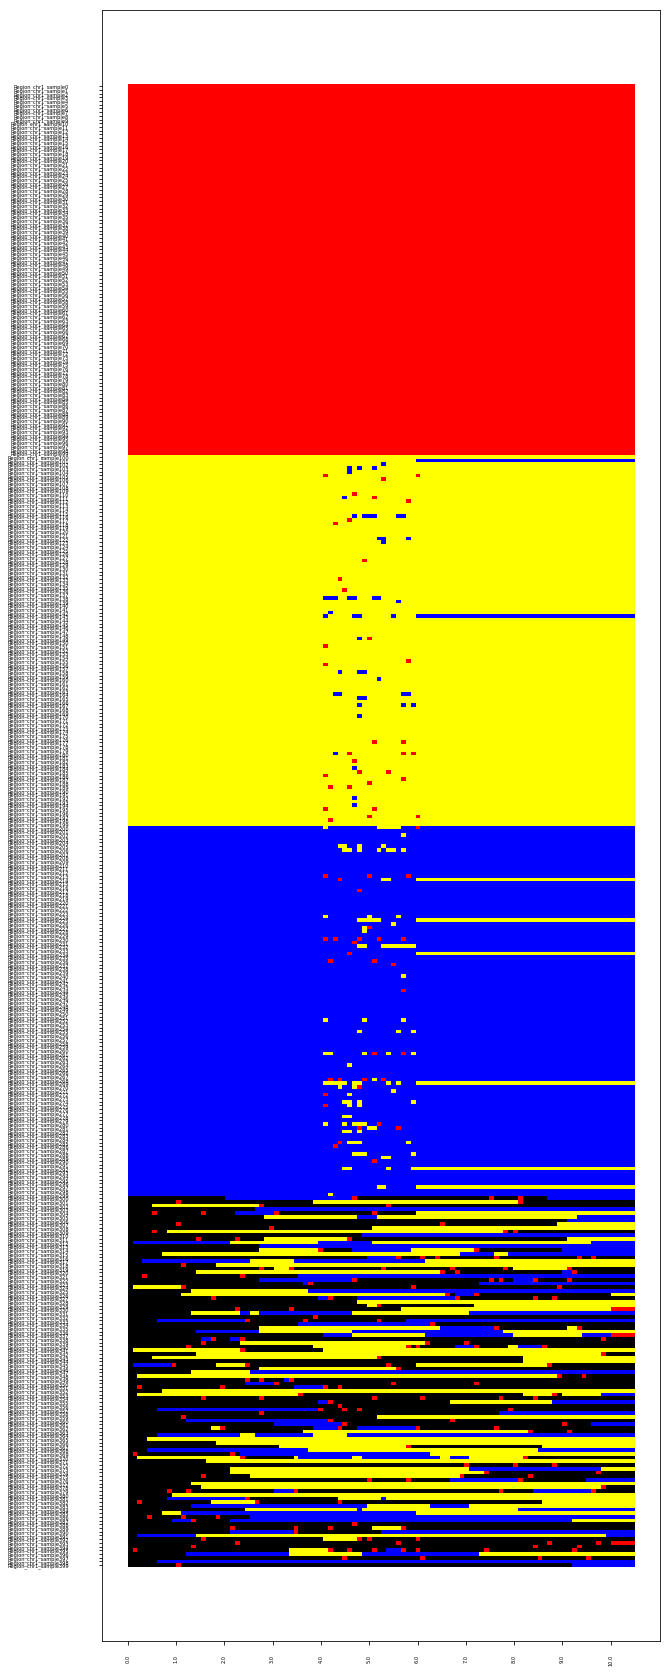

In [14]:
################
################        TRUTH

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

from Ideogram_tools import compress_ideo, return_ideogram, chromosome_collections
import re

import re
chromosome_list= []
chromosomes= [Chr]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list,Out)

ID= 'truth'

fig= return_ideogram(ideo, chromosome_list,ID)

In [ ]:
### KDE analysis across windows
from Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows

ref_labels= [1,2]

Comparison_threshold= 5
Outlier_threshold= 1e-5

KDE_windows(Windows,label_vector,ref_labels,Out,Comparison_threshold= Comparison_threshold,Outlier_threshold= Outlier_threshold)

In [14]:
#### ###

Haplotypes= np.concatenate(tuple([Windows[1][x] for x in Windows[1].keys()]), axis=1)

pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

feats= pca2.fit_transform(Haplotypes)

coords= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in list(set(label_vector))}


fig_data= [go.Scatter3d(
        x = feats[coords[i],0],
        y = feats[coords[i],1],
        z = feats[coords[i],2],
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    ) for i in coords.keys()]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)

adding ideograms...


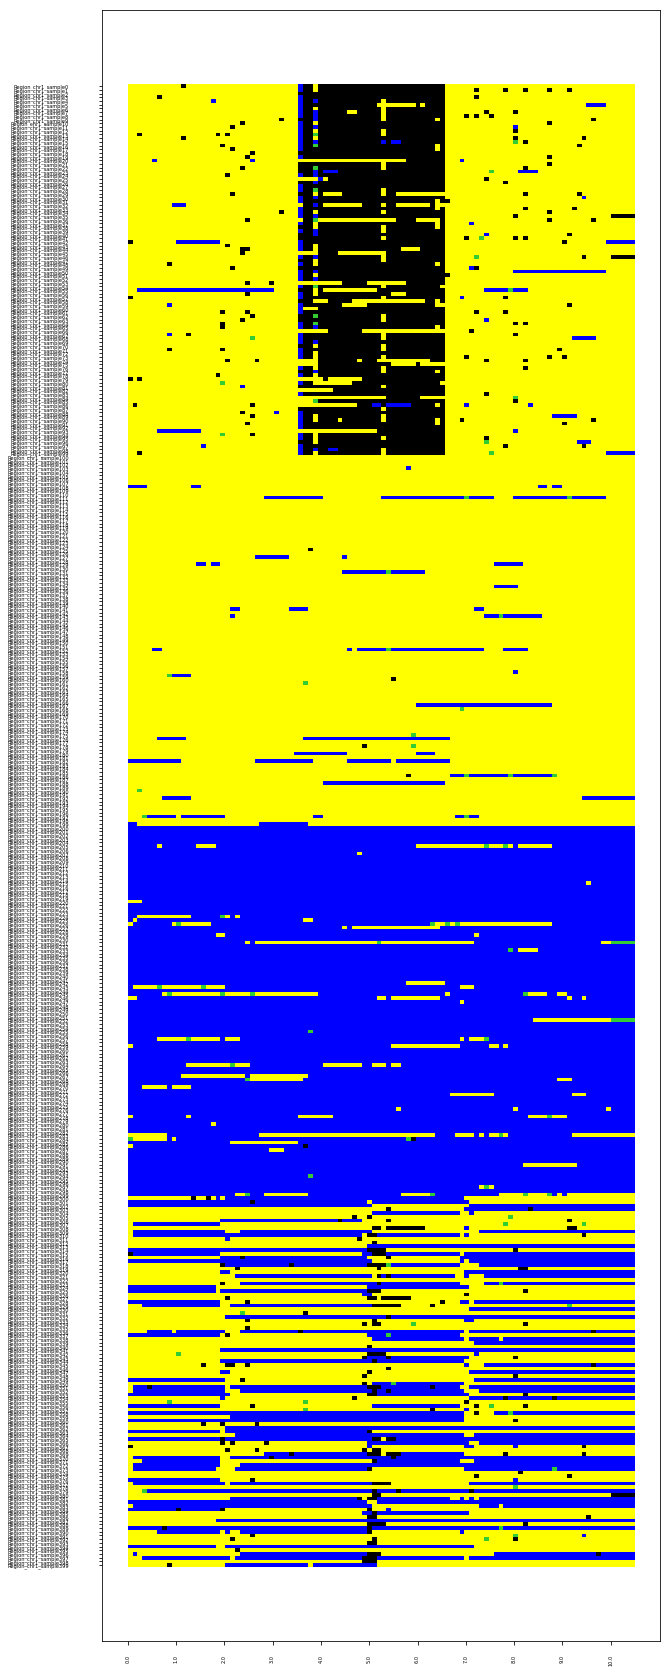

In [8]:

### Perform Distance and association analysis on the data sets generated

### Define reference and admixed associations:
### for the purpose of this analysis exploration will be driven by
### structure distance profiles. Since KDE will be used for exploration, 
### a set of accessions can be analysed that do not contribute to 
### distance profiles.

admx_N= 15
admx_indx= np.random.choice(range(sum(Sizes)),admx_N,replace= False)

ref_indx= [x for x in range(sum(Sizes)) if x not in admx_indx]

labels_pops= np.repeat(range(len(Sizes)),Sizes)

##

refs_lib= {x:[i for i in range(sum(Sizes)) if labels_pops[i] == x] for x in range(len(Sizes))}

admx_lib= {(max(refs_lib.keys()) + 1): admx_indx}


admx_lib.update(refs_lib)
Geneo= admx_lib

### Define parameters and libraries of analyses.
DIMr = 'PCA'
Bandwidth_split= 30
ncomp_local= 4
clsize= 15

Clover= []
Coordinates= []
Clusters_coords= []
PC_var= recursively_default_dict()

Dist_vectors= []

Distances= []
center_distances= []

Ref_stats= []
Ref_stats_lib= recursively_default_dict()

for CHR in SequenceStore.keys():
    print('going on CHR: '+ str(CHR))
    for bl in SequenceStore[CHR].keys():
        
        print('data set: {}'.format(bl))
        ### PCA and MeanShift of information from each window copied from *FM36_Galaxy.py.
        Sequences = SequenceStore[CHR][bl]
               
        Sequences= np.nan_to_num(Sequences)
        
        print(Sequences.shape)
        
        #### Dimensionality reduction
        
        if DIMr == 'PCA':
            pca = PCA(n_components=ncomp_local, whiten=False,svd_solver='randomized').fit(Sequences)
            data = pca.transform(Sequences)
            PC_var[CHR][bl]= [x for x in pca.explained_variance_]
        
        if DIMr == 'NMF':
            from sklearn.decomposition import NMF
            data = NMF(n_components=ncomp_local, init='random', random_state=0).fit_transform(Sequences)
        
        Accurate = []
        
        params = {'bandwidth': np.linspace(np.min(data), np.max(data),Bandwidth_split)}
        grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)
        
        ######################################
        ####### TEST global Likelihood #######
        ######################################
        Focus_labels = [z for z in it.chain(*refs_lib.values())]
        
        Who= refs_lib[0]
        Whose_parents= range(sum(Sizes))
        
        #Refs_local= [x for x in Whose_parents if x not in Who]
        Who_feat= data[Who,:]
        Ref_feat= data[Whose_parents,:]

        #### Normalize by distance between local centroids (to compensate for bias in sampling number).
        #### identify these clusters using MS.
        #### use reference accessions NOT in the cluster identified.
        Dpool= data[[x for x in Whose_parents if x not in Who],:]
        Pdistances= []

        bandwidth = estimate_bandwidth(Dpool, quantile=0.15)
        if bandwidth <= 0:
            bandwidth= .1
        params = {'bandwidth': np.linspace(np.min(Dpool), np.max(Dpool),30)}
        grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)

        ## perform MeanShift clustering.
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=False, min_bin_freq=25)
        ms.fit(Dpool)
        labels1 = ms.labels_
        label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1))) if y != -1}

        centers= [np.mean(Dpool[label_select[z],:],axis= 0) for z in label_select.keys()]

        #### Data set of evenly sampled data. ##
        ## We'll generate 50 new observations from each cluster identified locally. ##
        N= 50
        Proxy_data= []
        label_select_labels= [z for z in it.chain(*[[x] * len(label_select[x]) for x in label_select.keys()])]
        Center_store= {}
        Proxy_indexes= {}
        distance_vecs= []

        for lab in label_select.keys():
            if len(label_select[lab]) < 3:
                continue

            Quanted_set= Dpool[label_select[lab],:]

            if np.max(pairwise_distances(Quanted_set,metric= 'euclidean')) <= 1e-3:
                Extract= Quanted_set[np.random.choice(Quanted_set.shape[0],N),:]
            else:
                grid.fit(Quanted_set)
                kde = grid.best_estimator_
                Extract= kde.sample(N)

            center= np.mean(Extract,axis= 0)
            Center_store[lab]= center
            Proxy_indexes[lab]= [x for x in range((len(Center_store) - 1) * N, len(Center_store) * N)]

            Proxy_data.extend(Extract)

        Proxy_data= np.array(Proxy_data)
        ##### Get pairwise distances between centroids.

        for pair in it.combinations(label_select.keys(),2):
            coordinates= [np.mean(Dpool[label_select[z],:],axis= 0) for z in pair]
            coordinates= np.array(coordinates)
            iu_control= np.triu_indices(2,1)
            MS_pair_dist= pairwise_distances(coordinates,metric= 'euclidean')
            MS_pair_dist= MS_pair_dist[iu_control][0]
            Pdistances.append(MS_pair_dist)
        ## 

        reference_centroid= np.mean(centers,axis= 0)

        proxy_distances= pairwise_distances(reference_centroid.reshape(1,-1), Proxy_data,metric= 'euclidean')
        distances_to_center= pairwise_distances(reference_centroid.reshape(1,-1), Ref_feat,metric= 'euclidean')[0]
        self_distances= pairwise_distances(reference_centroid.reshape(1,-1), Who_feat, metric= 'euclidean')

        centroid= np.mean(Who_feat,axis= 0)
        distances_pairwise= pairwise_distances(centroid.reshape(1,-1), Ref_feat,metric= 'euclidean')[0]

        Distances.append(distances_pairwise)
        distances_pairwise= [(x - np.mean(proxy_distances)) / np.std(proxy_distances) for x in distances_pairwise]
        Clover.append(distances_pairwise)
        print(np.array(Clover).shape)

        FC_stats= [np.mean(proxy_distances),np.std(proxy_distances), np.mean(self_distances), np.std(self_distances)]
        Coord= [[CHR,bl,x] for x in Who]

        Ref_stats.append(FC_stats)
        Ref_stats_lib[CHR][bl]= FC_stats

        center_distances.append(distances_to_center)
        
        Coordinates.extend(Coord)
        Clusters_coords.append([CHR,bl])



going on CHR: 1
data set: -10000
(400, 150)
(1, 400)
data set: -9797
(400, 150)
(2, 400)
data set: -9595
(400, 150)
(3, 400)
data set: -9393
(400, 150)
(4, 400)
data set: -9191
(400, 150)
(5, 400)
data set: -8989
(400, 150)
(6, 400)
data set: -8787
(400, 150)
(7, 400)
data set: -8585
(400, 150)
(8, 400)
data set: -8383
(400, 150)
(9, 400)
data set: -8181
(400, 150)
(10, 400)
data set: -7979
(400, 150)
(11, 400)
data set: -7777
(400, 150)
(12, 400)
data set: -7575
(400, 150)
(13, 400)
data set: -7373
(400, 150)
(14, 400)
data set: -7171
(400, 150)
(15, 400)
data set: -6969
(400, 150)
(16, 400)
data set: -6767
(400, 150)
(17, 400)
data set: -6565
(400, 150)
(18, 400)
data set: -6363
(400, 150)
(19, 400)
data set: -6161
(400, 150)
(20, 400)
data set: -5959
(400, 150)
(21, 400)
data set: -5757
(400, 150)
(22, 400)
data set: -5555
(400, 150)
(23, 400)
data set: -5353
(400, 150)
(24, 400)
data set: -5151
(400, 150)
(25, 400)
data set: -4949
(400, 150)
(26, 400)
data set: -4747
(400, 150)
(27

In [12]:

Ref_stats= np.array(Ref_stats)
Clover= np.array([x for x in Clover])
Coordinates= np.array(Coordinates)
Clusters_coords= np.array(Clusters_coords)
Distances= np.array(Distances)
center_distances= np.array([x for x in center_distances])
#center_distances= np.array([x.reshape(1,-1)[0] for x in center_distances])

from sklearn import preprocessing


### initial step of  filtering.
### removing windows where variation between references resulted
### in normalized min and maximum distances above threshold. 
###

Trim_threshold= 20

trim_indexes= [x for x in range(Clover.shape[0]) if \
    min(Clover[x]) >= -Trim_threshold and max(Clover[x]) <= Trim_threshold and \
    min(center_distances[x]) >= -Trim_threshold and max(center_distances[x]) <= Trim_threshold]



Ref_stats= Ref_stats[trim_indexes]
Distances= Distances[trim_indexes]
Clover= Clover[trim_indexes]
center_distances= center_distances[trim_indexes]
Clusters_coords= Clusters_coords[trim_indexes]



In [13]:
np.array(Clover).shape

(100, 400)

In [14]:
variation_focus= range(len(Whose_parents))

### PCA
pca = PCA(n_components=5, whiten=False).fit(Clover.T)
X_se = pca.transform(Clover.T)
COMPS81 = pca.components_.T*np.sqrt(pca.explained_variance_)

###############################################################################
###############################################################################
###############################################################################


###### compare decompositions:
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
data= recursively_default_dict()

dr_names= ['PCA','FA','FastICA']
Decoms= [PCA(n_components= 5),FactorAnalysis(n_components= 5)]
###

label_store= []

for decom in range(len(Decoms)):
    dr= Decoms[decom].fit(Clover)
    COMPS= dr.transform(Clover)
    
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=10, random_state=0).fit(COMPS)
    labels1 = kmeans.labels_
    
    label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}
    
    Cameo = []
    
    for cramp in sorted(label_select.keys()):
        Clamp = np.mean(Clover[label_select[cramp],:],axis = 0)
        Fry = [x for x in Clamp]
        Cameo.append(Fry)
    
    Cameo = np.array(Cameo).T
    print(Cameo.shape)
    print(Cameo[:5,:5])
    COMPS= pd.DataFrame(COMPS,columns= ['pc{}'.format(x+1) for x in range(COMPS.shape[1])])
    COMPS['label']= labels1
    
    data[dr_names[decom]]= {
        'features': COMPS,
        'KDE':pd.DataFrame(Cameo),
        'stats': recursively_default_dict(),
        'labels_l1': labels1
    }
    
    print(Cameo[:5,:5])
    labels_second_layer= [-1]*Distances.shape[0]
    
    for Cl in label_select.keys():
        if len(label_select[Cl]) <= len(label_select):
            continue
        ## retrieve distances to centroids selected
        New_comp= Distances[[x for x in label_select[Cl]]]
        ## identify problem rows.
        NAs_row= [sum(np.isnan(New_comp[x])) for x in range(New_comp.shape[0])]
        NAs_row= [x for x in range(len(NAs_row)) if NAs_row[x] == New_comp.shape[1]]
        ## remove problem rows.
        New_comp= New_comp[[x for x in range(New_comp.shape[0]) if x not in NAs_row]]
        ## retrieve distances to global center for centroids selected
        distance_to_center= center_distances[[x for x in label_select[Cl]]]
        distance_to_center= distance_to_center[[x for x in range(New_comp.shape[0]) if x not in NAs_row]]
        
        ### PCA on Distances
        pca= PCA(n_components= 3,whiten= False).fit(New_comp)
        new_feat= pca.transform(New_comp)
        clock = pca.components_.T*np.sqrt(pca.explained_variance_)
        
        ## Kmeans in feature space
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=8, random_state=0).fit(new_feat)
        new_labels = kmeans.labels_
        another_label_select = {y:[x for x in range(len(new_labels)) if new_labels[x] == y] for y in sorted(list(set(new_labels)))}
        
        ### set up second layer of labels:
        for color in another_label_select.keys():
            for thot in range(len(another_label_select[color])):
                if another_label_select[color][thot] not in NAs_row:
                    indexed= label_select[Cl][another_label_select[color][thot]]
                    labels_second_layer[indexed]= color
        
        ### average distances across clustered profiles.
        Cameo = []
        center_means= []
        for cramp in sorted(another_label_select.keys()):
            Fry = np.mean(New_comp[another_label_select[cramp],:],axis = 0)
            Phillip= np.mean(distance_to_center[another_label_select[cramp],:],axis = 0)
            
            center_means.append(Phillip)
            Cameo.append(Fry)
        
        ### prepare data to save
        Cameo = np.array(Cameo).T
        center_means= np.array(center_means).T
        
        new_feat= pd.DataFrame(new_feat,columns= ['pc{}'.format(x+1) for x in range(new_feat.shape[1])])
        new_feat['label']= new_labels
        
        clock= pd.DataFrame(clock, columns= ['pc{}'.format(x+1) for x in range(clock.shape[1])])
        #clock['id']= [Fam[x] for x in Parent_list]
                
        data[dr_names[decom]]['stats'][Cl]= {
            'profiles': new_feat,
            'features': clock,
            'averages': pd.DataFrame(Cameo),
            'shapes': pd.DataFrame(center_means)
        }
    data[dr_names[decom]]['labels_l2']= labels_second_layer
    


data['Ref_stats']= Ref_stats
data['Distances']= Distances
data['centre_dists']= center_distances



(400, 10)
[[-2.59097966 -2.89481757 -2.51942938 -1.63710163 -2.3143254 ]
 [-2.90740165 -2.69768597 -3.03733443 -0.94090546 -2.80543543]
 [-3.04981349 -2.98333807 -2.70809254 -2.1349419  -2.36330209]
 [-3.22730501 -3.23903579 -1.84228649 -2.04455463 -2.73564842]
 [-3.16839789 -3.29168372 -2.62019903 -1.78975888 -2.58755727]]
[[-2.59097966 -2.89481757 -2.51942938 -1.63710163 -2.3143254 ]
 [-2.90740165 -2.69768597 -3.03733443 -0.94090546 -2.80543543]
 [-3.04981349 -2.98333807 -2.70809254 -2.1349419  -2.36330209]
 [-3.22730501 -3.23903579 -1.84228649 -2.04455463 -2.73564842]
 [-3.16839789 -3.29168372 -2.62019903 -1.78975888 -2.58755727]]
(400, 10)
[[-2.71997967 -2.72747001 -2.83571914 -2.75192737 -2.51942938]
 [-2.67892047 -3.07686283 -2.90009203 -2.90120293 -3.03733443]
 [-3.26240874 -3.19686023 -2.46669847 -3.10106294 -2.70809254]
 [-3.05642544 -3.06343469 -2.40658948 -3.18745248 -1.84228649]
 [-3.10602784 -3.07699764 -2.3671783  -3.50837504 -2.62019903]]
[[-2.71997967 -2.72747001 -2.835

In [15]:
### Cluster proportions
### Select feature reduction:
Dr= 'PCA'
clusters_labels= data[Dr]['labels_l1']

def paint_bars(selected):
    clusters= data[Dr]['features']
    if selected == 0:
        color_range = ['rgb(158,202,225)'] * len(list(set(clusters.iloc[:,0])))
    else:
        color_range = ['rgb(158,202,225)'] * len(list(set(clusters.iloc[:,0])))
        color_range[selected - 1] = 'rgb(204,0,0)'
    
    whom= sorted(list(set(clusters_labels)))
    nb= [round(len([x for x in clusters_labels if x == y]) / float(len(clusters_labels)),3) for y in whom]
    nc= [str(x + 1) for x in whom]
    trace = [go.Bar(
    x= nc,
    y= nb,
    text= nb,
    marker=dict(
        color= color_range,
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
    ),
    opacity= .6
    )]
    layout= go.Layout(
    title= 'cluster proportions',
    xaxis= dict(
        title= 'MS clusters'
    ),
    yaxis= dict(
        title= '%'
    )
    )
    fig= go.Figure(data=trace,layout=layout)
    iplot(fig)

interact(paint_bars,selected= [x for x in range(len(list(set(clusters_labels)))+1)])




interactive(children=(Dropdown(description='selected', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.paint_bars>

In [16]:

### plot clusters:
clusters_labels= data[Dr]['labels_l1']
clusters= data[Dr]['features']

def plot_clusters(selected):
    scheme = [x for x in list(set(clusters_labels))]
    if selected == 0:
        opac_range = [.8]*len(list(set(clusters_labels)))
    else:
        opac_range = [.3]*len(list(set(clusters_labels)))
        opac_range[selected-1] = 1
    fig_data= [go.Scatter(
        y = clusters.iloc[[x for x in range(len(clusters_labels)) if clusters_labels[x] == i],:].pc1,
        x = clusters.iloc[[x for x in range(len(clusters_labels)) if clusters_labels[x] == i],:].pc2,
        #z = clusters.iloc[[x for x in range(len(clusters_labels)) if clusters_labels[x] == i],:].pc3,
        #type='scatter',
        mode= "markers",
        marker= {
            'line': {'width': 0},
            'size': 4,
            'symbol': 'circle',
            'opacity': opac_range[i]
          },
          name = str(i + 1)
        ) for i in scheme]
    
    layout = go.Layout(
        title= 'Distance to references PCA',
        xaxis= dict(
            title= 'PC2'
        ),
        yaxis= dict(
            title= 'PC1'
        ),
        showlegend= True
        )
    
    fig = go.Figure(data=fig_data, layout=layout)
    iplot(fig)

interact(plot_clusters,selected= [x for x in range(len(clusters.label.unique())+1)])

interactive(children=(Dropdown(description='selected', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_clusters>

In [30]:
df= pd.DataFrame(X_se,columns= None)

Centre_distances= data['centre_dists']
Ref_stats= data['Ref_stats']

ID= prior + ' sim'

In [18]:
### plot loadings:
vectors= data['PCA']['KDE']

def plot_accessions(selected_column):
    
    layout= go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        xaxis= dict(
            title= 'PC1',
        ),
        showlegend= True
        )
    #names_index = [[f for f in orderCore.ID].index(x) for x in [str(y) for y in df.iloc[:,1]]]
    opac= .8
    if selected_column == 0:
        scheme = labels_pops
        coords = {y:[x for x in range(len(scheme)) if scheme[x] == y and x ] for y in list(set(scheme))}
        
        #pop_refs= ["Indica","cAus","Japonica","GAP","cBasmati","Admix"]
        #color_here= color_ref
        
        fig= [go.Scatter3d(
        x = df.iloc[coords[i],2],
        y = df.iloc[coords[i],3],
        z = df.iloc[coords[i],4],
        #type='scatter3d',
        mode= "markers",
        marker= {
#        'color': scheme,
        'color': i,
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": opac
      },
      name= str(i)
    ) for i in coords.keys() if i != 0]
    
    if selected_column > 0:
        fig= [go.Scatter3d(
            x = df.iloc[:,2],
            y = df.iloc[:,3],
            z = df.iloc[:,4],
            #type='scatter3d',
            mode= "markers",
        marker= {
            'color': vectors.iloc[:,selected_column - 1],
                'colorbar': go.ColorBar(
                    title= 'ColorBar'
                ),
            'colorscale': 'Viridis',
            'line': {'width': 0},
            'size': 4,
            'symbol': 'circle',
          "opacity": opac
          }
        )]
            
    fig = go.Figure(data=fig,layout= layout)
    iplot(fig)

interact(plot_accessions,selected_column= [x for x in range(len(clusters.label.unique())+1)])    

interactive(children=(Dropdown(description='selected_column', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_accessions>

In [19]:
def return_densities(label):
    select_l1= [label]
    selected1= [x for x in range(Distances.shape[0]) if data[Dr]['labels_l1'][x] + 1 in select_l1]    

    x= np.mean(Distances[selected1,:],axis= 0)
    y= np.mean(Centre_distances[selected1,:],axis= 0)

    fig= [go.Scatter(
        x= x,
        y= y,
        mode= 'markers'  
    )]

    colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]

    trace1 = go.Scatter(
        x=x, y=y, mode='markers', name='points',
        marker=dict(color='rgb(102,0,0)', size=5, opacity=0.4)
    )
    trace2 = go.Histogram2dContour(
        x=x, y=y, name='density', ncontours=20,
        colorscale='Hot', reversescale=True, showscale=False
    )
    trace3 = go.Histogram(
        x=x, name='x density',
        marker=dict(color='rgb(102,0,0)'),
        yaxis='y2'
    )
    trace4 = go.Histogram(
        y=y, name='y density', marker=dict(color='rgb(102,0,0)'),
        xaxis='x2'
    )
    fig= {'data':[trace1, trace2, trace3, trace4]}

    fig['layout'] = go.Layout(
        showlegend=False,
        autosize=True,
        #width=1200,
        #height=550,
        xaxis=dict(
            domain=[0, 0.85],
            showgrid=False,
            zeroline=False
        ),
        yaxis=dict(
            domain=[0, 0.85],
            showgrid=False,
            zeroline=False
        ),
        margin=dict(
            t=50
        ),
        hovermode='closest',
        bargap=0,
        xaxis2=dict(
            domain=[0.85, 1],
            showgrid=False,
            zeroline=False
        ),
        yaxis2=dict(
            domain=[0.85, 1],
            showgrid=False,
            zeroline=False
        )
    )
    

    iplot(fig)

interact(return_densities,label= range(1,11))

interactive(children=(Dropdown(description='label', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output()), _dom_classes=('widget-interact',))

<function __main__.return_densities>

In [20]:
def return_refs(label,Z):
    select_l1= [label]
    selected1= [x for x in range(Distances.shape[0]) if data[Dr]['labels_l1'][x] + 1 in select_l1]    
    
    #names_index = [[f for f in orderCore.ID].index(x) for x in [str(y) for y in df.iloc[:,1]]]

    ###
    scheme = labels_pops
    coords = {y:[x for x in range(len(scheme)) if scheme[x] == y and x ] for y in list(set(scheme))}
    
    print(coords.keys())
    pop_refs= ["Indica","cAus","Japonica","GAP","cBasmati","Admix"]
    #color_here= color_ref

    ###
    
    ref_names= ['Indica','cAus','Japonica','cBasmati','Admix']

    #scheme= [orderCore.loc[x,'sNMF_K3'] for x in names_index]
    #scheme= {z:[x for x in range(len(scheme)) if scheme[x] == z] for z in list(set(scheme))}
    if Z== 0:
        x= np.mean(Distances[selected1,:],axis= 0)
        print(len(scheme))
        y= np.mean(Centre_distances[selected1,:],axis= 0)
        
        max_dists= [max(Centre_distances[x]) for x in selected1]
        min_centre= [min(Distances[x]) for x in selected1]
        
        Normalized_mean= np.mean(max_dists)
        Normalized_centre= np.mean(min_centre)
        
    if Z== 1:
        meansVars= Ref_stats[selected1,:]
        trim= [x for x in range(meansVars.shape[0]) if meansVars[x,1] > 0.05]
        
        max_dists= [max(Centre_distances[x]) for x in selected1]
        min_centre= [min(Distances[x]) for x in selected1]
        meansVars= meansVars[trim,:]
        select_trim= [selected1[x] for x in trim]
        
        Normalized_mean = [(max_dists[x] - meansVars[x,0]) / meansVars[x,1] for x in range(meansVars.shape[0])]
        Normalized_mean= np.array(Normalized_mean)
        #Normalized_mean= [x for x in Normalized_mean if np.isnan()]
        Normalized_mean[Normalized_mean > 20] = 10
        Normalized_mean[Normalized_mean < -20] = -10
        Normalized_mean= np.mean(Normalized_mean)
        
        Normalized_centre = [(min_centre[x] - meansVars[x,0]) / meansVars[x,1] for x in range(meansVars.shape[0])]
        Normalized_centre= np.array(Normalized_centre)
        #Normalized_mean= [x for x in Normalized_mean if np.isnan()]
        Normalized_centre[Normalized_centre > 20] = 10
        Normalized_centre[Normalized_centre < -20] = -10
        Normalized_centre= np.mean(Normalized_centre)
        
        sel_d= Distances[select_trim,:]
        sel_d= [(sel_d[x] - meansVars[x,0]) / meansVars[x,1] for x in range(len(select_trim))]
        x= np.mean(sel_d,axis=0)
        
        sel_refd=Centre_distances[select_trim,:]
        sel_refd= [(sel_refd[x] - meansVars[x,0]) / meansVars[x,1] for x in range(len(select_trim))]
        y= np.mean(sel_refd,axis=0)

    
    trace1 = [go.Scatter(
        x= [x[z] for z in coords[i]],
        y= [y[z] for z in coords[i]],
        mode= 'markers',
        name= ref_names[i],
        marker=dict(color=i, size=7, opacity=0.6)
    ) for i in coords.keys()]# if coords[i] and i != 5]


    trace1.append(go.Scatter(
        x= [Normalized_centre],
        y= [Normalized_mean],
        mode= 'markers',
        marker=dict(color='black', size=10, opacity=0.6)
    ))

    layout = go.Layout(
        title= 'distances label {}; Target mean: {}'.format(select_l1[0],round(Normalized_mean,2)),
        showlegend=False,
        autosize=True,
        xaxis= dict(
        range= [-15,14],
        title= 'PCA euc distances'
        ),
        yaxis= dict(
        range= [-2,14],
        title= 'PCA distances to center')
    )

    fig= go.Figure(data=trace1,layout= layout)

    iplot(fig)

interact(return_refs,label= range(1,11),Z= [0,1])

interactive(children=(Dropdown(description='label', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Dropdown(description='Z', options=(0, 1), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.return_refs>

In [31]:
### Distribution of feature space distances between control populations for even and biased scenarios
from sklearn.neighbors import KernelDensity

select_l1= range(11)
selected1= [x for x in range(Distances.shape[0]) if data[Dr]['labels_l1'][x] + 1 in select_l1]    

Means= Ref_stats[selected1,0]
Varsity= Ref_stats[selected1,1]

target_mean= Ref_stats[selected1,2]
target_var= Ref_stats[selected1,3]

Normalized_mean = [(target_mean[x] - Means[x]) / Varsity[x] for x in range(len(selected1))]
Normalized_mean= np.nan_to_num(Normalized_mean)
Normalized_mean[Normalized_mean > 20] = 10
Normalized_mean[Normalized_mean < -20] = -10


max_vec= [Centre_distances[x][[y for y in Distances[x]].index(min(Distances[x]))] for x in selected1]
max_vec= [(max_vec[x] - Means[x]) / Varsity[x] for x in range(len(selected1))]
max_vec= np.nan_to_num(max_vec)
max_vec[max_vec > 40] = 10
max_vec[max_vec < -40] = -10

max_dist= [max(Distances[x]) for x in selected1]
max_dist= [(max_dist[x] - Means[x]) / Varsity[x] for x in range(len(selected1))]
max_dist= np.nan_to_num(max_dist)
max_dist[max_dist > 40] = 10
max_dist[max_dist < -40] = -10


###
###

X_plot = np.linspace(min(Means) - 2, max(Means) + 2, 1000)

kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(np.array(Means).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'Ref mean',
                            line=dict(color='blue', width=2))]

## Change means and variances to those of selected clusters


##

X_plot = np.linspace(min(Normalized_mean) - 2, max(Normalized_mean) + 2, 1000)

kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(np.array(Normalized_mean).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_roost_dens.append(go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'Target mean',
                            line=dict(color='red', width=2)))


Dists_mean= np.mean(Normalized_mean)
Dists_std= np.std(Normalized_mean)

from scipy.stats import norm

Dists_endpoints= norm.interval(0.95, loc=Dists_mean, scale=Dists_std)
print(Dists_endpoints)


layout= go.Layout(
    title= '{}, Ztarget and normal Dists.'.format(ID),
    xaxis= dict(
    range= [-5,20]
    )
)

fig = go.Figure(data=fig_roost_dens, layout= layout)
iplot(fig)

(-5.1121578692814085, 7.261633075980046)


In [32]:
##
X_plot = np.linspace(min(Varsity) - 2, max(Varsity) + 2, 1000)

kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(np.array(Varsity).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_vars_dens = [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'Ref SD',
                            line=dict(color='blue', width=2))]


##
X_plot = np.linspace(min(target_var) - 2, max(target_var) + 2, 1000)

kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(np.array(target_var).reshape(-1,1))

log_dens = kde.score_samples(X_plot.reshape(-1,1))

fig_vars_dens.append(go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= 'target SD',
                            line=dict(color='red', width=2)))

##

layout= go.Layout(
    title= '{}, Variation across target and reference clusters'.format(ID)
)

fig = go.Figure(data=fig_vars_dens, layout= layout)
iplot(fig)

In [33]:
threshold= 2

coords_threshold= [int(x > threshold) for x in max_vec]
coords_threshold= {z:[x for x in range(len(coords_threshold)) if coords_threshold[x] == z] for z in list(set(coords_threshold))}

prop_thresh= round(len(coords_threshold[1]) / float(len(Normalized_mean)) * 100,2)

fig_data= [go.Scatter(
    x= [clusters.pc1[x] for x in coords_threshold[i]],
    #x= [max_vec[x] for x in coords_threshold[i]],
    #y= [max_dist[x] for x in coords_threshold[i]],
    y= [Normalized_mean[x] for x in coords_threshold[i]],
    mode= 'markers',
    name= '{} {}'.format(['<=','>'][i],threshold),
    marker= dict(
        color= ['grey','red'][i]
    )
    ) for i in coords_threshold.keys()
]

layout = go.Layout(
    title= '{}, {} % observations above threshold'.format(ID,prop_thresh),
    yaxis=dict(
        title='Distance',
    range= [-10,40]),
    xaxis=dict(
        title='PC1')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [34]:
coords_threshold.keys()

dict_keys([0, 1])

In [37]:
from Generate_freq_vectors import generate_Branches_Beta
from Euc_to_fst import Euc_to_fst

Nbranches= 4
L= 150
n= 100
rangeA= [1,2.5]
rangeB = [.1,.6]
steps= 20
n_comp = 100
density= 50


#vector_lib= generate_vectors_Beta(L,n,rangeA,rangeB,steps,n_comp)

#pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
#features = pca.transform(vector_lib)


features, vector_lib= generate_Branches_Beta(4,50,L,n,rangeA,rangeB,steps,n_comp)
print(features.shape)
print(vector_lib.shape)

(200, 100)
(200, 150)


In [39]:
m_coeff, b, fst_x, y_true= Euc_to_fst(vector_lib)

length haps: 150, N iterations: 20, range pops: 8


C:\Users\jgarcia\Desktop\Jupyter_stuff\Genetic-data-analysis\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



In [40]:

def return_refs(t1,t2,registered,Z):
    
    
    Normalized_mean = [(target_mean[x] - Means[x]) / Varsity[x] for x in range(len(target_mean))]
    
    max_vec= [Centre_distances[x][[y for y in Distances[x]].index(min(Distances[x]))] for x in range(len(Means))]
    Normalized_vec= [(max_vec[x] - Means[x]) / Varsity[x] for x in range(len(Means))]

    if registered == 'inlier':
        t1= Dists_endpoints[0]
        t2= Dists_endpoints[1]
        #Normalized_mean= Normalized_vec
     
    Normalized_mean= np.nan_to_num(Normalized_mean)
    Normalized_mean[Normalized_mean > 20] = 10
    Normalized_mean[Normalized_mean < -20] = -10
    
    coords_threshold= [int(x >= t1 and x <= t2) for x in Normalized_mean]
    coords_threshold= {z:[x for x in range(len(coords_threshold)) if coords_threshold[x] == z]  for z in list(set(coords_threshold))}
    
    #names_index = [[f for f in orderCore.ID].index(x) for x in [str(y) for y in df.iloc[:,1]]]
    
    average_selected= round(np.mean([Normalized_mean[x] for x in coords_threshold[1] if Normalized_vec[x] > - 20 and Normalized_vec[x] < 20]),2)
    
    prop_thresh= round(len(coords_threshold[1]) / float(len(Normalized_mean)) * 100,2)
    
    selected1= coords_threshold[1]
    
    ###
    scheme = labels_pops
    coords = {y:[x for x in range(len(scheme)) if scheme[x] == y and x ] for y in list(set(scheme))}
    
    print(coords.keys())
    pop_refs= ["Indica","cAus","Japonica","GAP","cBasmati","Admix"]
    #color_here= color_ref

    ###
    
    ref_names= ['Indica','cAus','Japonica','cBasmati','Admix']

    #scheme= [orderCore.loc[x,'sNMF_K3'] for x in names_index]
    #scheme= {z:[x for x in range(len(scheme)) if scheme[x] == z] for z in list(set(scheme))}
    if Z== 'raw':

        X= np.mean(Distances[selected1,:],axis= 0)
        print(len(scheme))
        Y= np.mean(Centre_distances[selected1,:],axis= 0)
        
        max_dists= [max(Centre_distances[x]) for x in selected1]
        min_centre= [min(Distances[x]) for x in selected1]
        
        Normalized_mean= np.mean(max_dists)
        Normalized_centre= np.mean(min_centre)
        
    if Z== 'scaled':
        meansVars= Ref_stats[selected1,:]
        trim= [x for x in range(meansVars.shape[0]) if meansVars[x,1] > 0.05]
        
        meansVars= meansVars[trim,:]
        select_trim= [selected1[x] for x in trim]
        
        max_dists= [max(Centre_distances[x]) for x in select_trim]
        min_centre= [min(Distances[x]) for x in select_trim]
        
        average_selected= round(np.mean([Means[x] for x in select_trim if Normalized_vec[x] > - 20 and Normalized_vec[x] < 20]),2)
        
        sel_d= Distances[select_trim,:]
        sel_d= [(sel_d[x] - meansVars[x,0]) / meansVars[x,1] for x in range(len(select_trim))]
        X= np.mean(sel_d,axis=0)
        
        sel_refd=Centre_distances[select_trim,:]
        sel_refd= [(sel_refd[x] - meansVars[x,0]) / meansVars[x,1] for x in range(len(select_trim))]
        Y= np.mean(sel_refd,axis=0)

    if Z== 'Fst':

        X= np.mean(Distances[selected1,:],axis= 0)
        print(len(scheme))
        Y= np.mean(Centre_distances[selected1,:],axis= 0)
        
        X= [np.exp(m_coeff*np.log(x) + b) for x in X]
        Y= [np.exp(m_coeff*np.log(x) + b) for x in Y]
        
        max_dists= [max(Centre_distances[x]) for x in selected1]
        min_centre= [min(Distances[x]) for x in selected1]

    
    trace1 = [go.Scatter(
        visible = True,
        x= [X[z] for z in coords[i]],
        y= [Y[z] for z in coords[i]],
        mode= 'markers',
        name= str(i),
        marker=dict(color= i, size=7, opacity=0.6)
    ) for i in coords.keys()]# if coords[i] and i != 5]
    
    
    
    layout = go.Layout(
        title= '{} distances; % {}; Tz. > {} < {} local sd; sel: {}'.format(ID,prop_thresh,round(t1,2),round(t2,2),average_selected),
        showlegend=False,
        autosize=True,
        xaxis= dict(
        range= [-6,15],
        title= 'PCA euc distances'
        ),
        yaxis= dict(
        range= [-2,15],
        title= 'PCA distances to center')
    )

    fig= go.Figure(data=trace1,layout= layout)

    iplot(fig)

interact(return_refs,t1= range(-2,20),t2= range(2,20),Z= ['raw','scaled','Fst'],registered=['registered','inlier'])

interactive(children=(Dropdown(description='t1', options=(-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19), value=-2), Dropdown(description='t2', options=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19), value=2), Dropdown(description='registered', options=('registered', 'inlier'), value='registered'), Dropdown(description='Z', options=('raw', 'scaled', 'Fst'), value='raw'), Output()), _dom_classes=('widget-interact',))

<function __main__.return_refs>

In [169]:
test_guy= 12

In [165]:
range_cdist= [np.percentile(Centre_distances,1),np.percentile(Centre_distances,99),400]

####
N= 400
P= 40
Distances_mean= np.mean(Distances[selected1],axis= 0)


range_distances= [np.percentile(Focus_dist,1),np.percentile(Focus_dist,99),400]
range_cdist= [np.percentile(Focus_center,1),np.percentile(Focus_center,99),400]

params = {'bandwidth': np.linspace(.05,.3,10)}
grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)

In [166]:
distances_dens= []
Cdist_dens= []

i_coords, j_coords = np.meshgrid(np.linspace(range_distances[0],range_distances[1],P),
                      np.linspace(range_cdist[0],range_cdist[1],P),indexing= 'ij')
traces= [x for x in it.product(range(P),range(P))]

params_unique = {'bandwidth': np.linspace(.1, .3,20)}
grid_unique = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params_unique,verbose=0)

params_dens= {'bandwidth': np.linspace(.4, .8,20)}
grid_dens = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params_dens,verbose=0)

traces= [x for x in it.product(range(P),range(P))]

background= np.array([i_coords, j_coords])

background= [background[:,c[0],c[1]] for c in traces]
background=np.array(background)

for karl in range(Distances.shape[0]):
    
    """
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(Distances[karl,:])[:,np.newaxis])
    scores= kde.score_samples(np.linspace(*range_distances)[:,np.newaxis])
    
    
    distances_dens.append(scores)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(Centre_distances[karl,:])[:,np.newaxis])
    scores= kde.score_samples(np.linspace(*range_cdist)[:,np.newaxis])
    
    Cdist_dens.append(scores)
    
    
    ### Density measure
    datum = np.array([[Distances[karl,x],Centre_distances[karl,x]] for x in range(Distances.shape[1])])
    grid_dens.fit(datum)
    kde = grid_dens.best_estimator_

    P_dist= kde.score_samples(datum)
    scores= kde.score_samples(background)

    scores= np.exp(scores)
    scores= np.array([x for x in scipy.stats.norm(np.mean(scores),np.std(scores)).cdf(scores)])
    
    """
    ### haplotypes measure
    dotum= np.array([[Distances[karl,x],Centre_distances[karl,x]] for x in range(Distances.shape[1])])
    
    datum= np.unique(dotum,axis= 0)
    if len(datum) < 3:
        datum= dotum

    grid_unique.fit(datum)
    kde = grid_unique.best_estimator_

    P_dist= kde.score_samples(datum)
    scores_haps= kde.score_samples(background)
    scores_haps= np.exp(scores_haps)
    
    #scores= scores_haps
    scores= np.hstack((scores_haps))
    #
    Cdist_dens.append(scores)


#distances_dens= np.array(distances_dens)
Cdist_dens= np.array(Cdist_dens)
#coords= {i:[x for x in range(Distances.shape[0]) if data['labels_l1'][x] == i] for i in list(set(data['labels_l1']))}

In [170]:
### Cdist_dens must have been calculated.

N_view= 12

i_coords, j_coords = np.meshgrid(np.linspace(range_distances[0],range_distances[1],P),
                      np.linspace(range_cdist[0],range_cdist[1],P),indexing= 'ij')


traces= [x for x in it.product(range(P),range(P))]

background= np.array([i_coords, j_coords])

background= [background[:,c[0],c[1]] for c in traces]
background=np.array(background)

Xs= []
Ys= []
Zs= []
scores= []

for target in range(N_view):
    Xs.extend(background[:,0])
    Ys.extend(background[:,1])
    scores.extend(Cdist_dens[selected1[target],:P**2])
    Zs.extend([target] * background.shape[0])


thresho= .005
tie= [x for x in range(len((scores))) if scores[x] < thresho]


win= np.array([Xs,Ys,Zs,scores]).T
unmasked= win[[x for x in range(win.shape[0]) if x not in tie],:]

fig= [go.Scatter3d(
    x= unmasked[:,0],
    y= unmasked[:,1],
    z= unmasked[:,2],
    mode= 'markers',
    marker= {
        'color':unmasked[:,3],
        'colorbar': go.ColorBar(
            title= 'ColorBar'
        ),
        'colorscale':'Viridis',
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
)]


fig = go.Figure(data=fig)
iplot(fig)



In [171]:

params_unique = {'bandwidth': np.linspace(0, .2,20)}
grid_unique = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params_unique,verbose=0)

params_dens= {'bandwidth': np.linspace(.2, .6,20)}
grid_dens = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params_dens,verbose=0)

traces= [x for x in it.product(range(P),range(P))]

i_coords, j_coords = np.meshgrid(np.linspace(range_distances[0],range_distances[1],P),
                      np.linspace(range_cdist[0],range_cdist[1],P),indexing= 'ij')

background= np.array([i_coords, j_coords])

background= [background[:,c[0],c[1]] for c in traces]
background=np.array(background)

###
datum= np.array([[Distances[test_guy,x],Centre_distances[test_guy,x]] for x in range(Distances.shape[1])])
dotum= np.array([[Distances[test_guy,x],Centre_distances[test_guy,x]] for x in range(Distances.shape[1])])


### Density measure
grid_dens.fit(datum)
kde = grid_dens.best_estimator_

P_dist= kde.score_samples(datum)
scores= kde.score_samples(background)

scores= np.exp(scores)
scores= np.array([x for x in scipy.stats.norm(np.mean(scores),np.std(scores)).cdf(scores)])

### haplotypes measure
datum= np.unique(dotum,axis= 0)

grid_unique.fit(datum)
kde = grid_unique.best_estimator_

P_dist= kde.score_samples(datum)
scores_haps= kde.score_samples(background)
scores_haps= np.exp(scores_haps)

scores_combine= scores_haps


fig= [go.Scatter3d(
    x= background[:,0],
    y= background[:,1],
#    z= scores[[x for x in range(len(scores)) if scores[x] > 0]],
    z= scores_combine,
    mode= 'markers',
    marker= {
        'color':scores_combine,
        'colorbar': go.ColorBar(
            title= 'ColorBar'
        ),
        'colorscale':'Viridis',
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
)]


fig = go.Figure(data=fig)
iplot(fig)